# Galaxy Catalog Plots

This notebook reads the [LSST DM galaxy catalog](http://weaklensingdeblending.readthedocs.org/en/latest/catalog.html), calculates some size and shape parameters, and makes plots to summarize the inputs to the `simulate` program.  Plots to summarize the `simulate` outputs are generated in a [separate notebook](http://weaklensingdeblending.readthedocs.org/en/latest/notebooks.html).

## Initialization

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys
sys.path.append('..')
import descwl

## Read Galaxy Catalog

In [5]:
reader = descwl.catalog.Reader('../OneDegSq.fits')
catalog = reader.table
num_galaxies = len(catalog)

## Calculate Derived Quantities

In [6]:
beta = np.zeros(num_galaxies)
q_disk = np.zeros(num_galaxies)
q_bulge = np.zeros(num_galaxies)
hlr_disk = np.zeros(num_galaxies)
hlr_bulge = np.zeros(num_galaxies)

In [7]:
# Disk + bulge < 1 when an AGN component is present.
total_flux = catalog['fluxnorm_disk']+catalog['fluxnorm_bulge']+catalog['fluxnorm_agn']
frac_disk = catalog['fluxnorm_disk']/total_flux
frac_bulge = catalog['fluxnorm_bulge']/total_flux
# Disk and bulge position angles are the same when both components are present.
has_disk = (catalog['fluxnorm_disk'] > 0)
has_bulge = (catalog['fluxnorm_bulge'] > 0)
has_both = np.logical_and(has_disk,has_bulge)
assert np.array_equal(catalog['pa_disk'][has_both],catalog['pa_bulge'][has_both])
beta[has_disk] = np.radians(catalog['pa_disk'][has_disk])
beta[has_bulge] = np.radians(catalog['pa_bulge'][has_bulge])
# Calculate size and shape parameters for each component.
q_disk[has_disk] = catalog['b_d'][has_disk]/catalog['a_d'][has_disk]
q_bulge[has_bulge] = catalog['b_b'][has_bulge]/catalog['a_b'][has_bulge]
hlr_disk[has_disk] = np.sqrt(catalog['a_d'][has_disk]*catalog['b_d'][has_disk])
hlr_bulge[has_bulge] = np.sqrt(catalog['a_b'][has_bulge]*catalog['b_b'][has_bulge])

In [218]:
# Fraction of sources with disk + bulge mixtures
num_mixed = np.count_nonzero(np.logical_and(has_disk,has_bulge))
print '%d of %d galaxies (%.1f%%) have disk+bulge mixtures' % (
    num_mixed,num_galaxies,100.*num_mixed/num_galaxies)

252020 of 858043 galaxies (29.4%) have disk+bulge mixtures


In [8]:
Q = np.zeros((num_galaxies,2,2))
for i,row in enumerate(catalog):
    if has_disk[i]:
        Q[i] += frac_disk[i]*descwl.model.sersic_second_moments(1,hlr_disk[i],q_disk[i],beta[i])
    if has_bulge[i]:
        Q[i] += frac_bulge[i]*descwl.model.sersic_second_moments(1,hlr_bulge[i],q_bulge[i],beta[i])

In [9]:
sigma_m,sigma_p,a,b,beta2,e1,e2 = descwl.model.moments_size_and_shape(Q)

In [214]:
emag = np.sqrt(e1**2+e2**2)
erms = lambda mask: 0.5*(np.std(e1[mask])+np.std(e2[mask]))

In [205]:
ri_color = catalog['r_ab']-catalog['i_ab']

## Reproduce Fig 1 of Chang 2013

Chang 2013 is available at http://arxiv.org/abs/1305.0793 and published as [Mon. Not. R. Astron. Soc. 434, 2121 (Sep. 2013)](http://dx.doi.org/10.1093/mnras/stt1156). Note that there was an [erratum](http://dx.doi.org/10.1093/mnras/stu2553) submitted Oct 2014 (v3 on arxiv) that changes Fig.1(c).

Note that the subplots below are in a slightly different order than in the paper, to simplify the layout, but the labels (a-f) match those used in the paper.

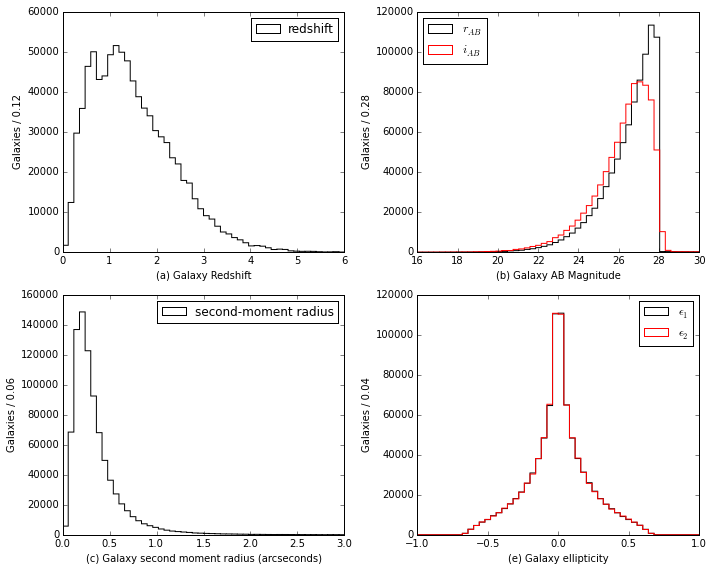

In [10]:
nbins = 50;
fig1abce = plt.figure(figsize=(10,8));
plt.subplot(2,2,1);
plt.hist(catalog['redshift'],bins=nbins,range=(0,6),histtype='step',color='black',label='redshift');
plt.xlabel('(a) Galaxy Redshift');
plt.ylabel('Galaxies / %.2f' % (6./nbins));
plt.legend();
plt.subplot(2,2,2);
plt.hist(catalog['r_ab'],bins=nbins,range=(16,30),histtype='step',color='black',label='$r_{AB}$');
plt.hist(catalog['i_ab'],bins=nbins,range=(16,30),histtype='step',color='red',label='$i_{AB}$');
plt.xlabel('(b) Galaxy AB Magnitude');
plt.ylabel('Galaxies / %.2f' % ((30.-16.)/nbins));
plt.legend(loc = 'upper left');
plt.subplot(2,2,3);
plt.hist(sigma_p,bins=nbins,range=(0,3),histtype='step',color='black',label='second-moment radius');
plt.xlabel('(c) Galaxy second moment radius (arcseconds)');
plt.ylabel('Galaxies / %.2f' % (3./nbins));
plt.legend();
plt.subplot(2,2,4);
plt.hist(e1,bins=nbins,range=(-1,+1),histtype='step',color='black',label='$\epsilon_1$');
plt.hist(e2,bins=nbins,range=(-1,+1),histtype='step',color='red',label='$\epsilon_2$');
plt.xlabel('(e) Galaxy ellipticity');
plt.ylabel('Galaxies / %.2f' % (2./nbins));
plt.legend();
plt.tight_layout();

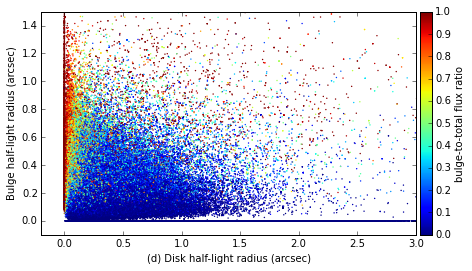

In [37]:
fig1d = plt.figure(figsize=(8,4));
plt.xlim(-0.2,3);
plt.ylim(-0.1,1.5);
plt.scatter(hlr_disk,hlr_bulge,s=2,c=frac_bulge,lw=0,rasterized=True);
plt.xlabel('(d) Disk half-light radius (arcsec)');
plt.ylabel('Bulge half-light radius (arcsec)');
plt.colorbar(label='bulge-to-total flux ratio',pad=0.01);

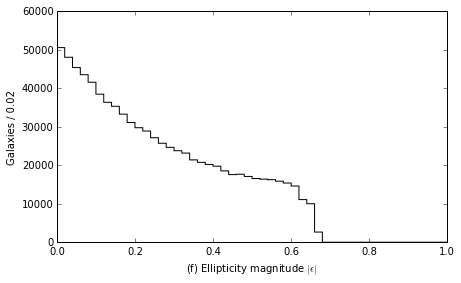

In [117]:
nbins = 50;
fig1f = plt.figure(figsize=(6.5,4));
plt.hist(emag,bins=nbins,range=(0,1),histtype='step',color='black');
plt.xlabel('(f) Ellipticity magnitude $|\epsilon|$');
plt.ylabel('Galaxies / %.2f' % (1./nbins));
plt.tight_layout();

## Prepare Figure for Paper

In [209]:
area = 60.*60. # sq. arcmin.
wgt=np.empty(num_galaxies)
wgt[:]=1./area
print 'Total catalog galaxies %ld = %.3f /sq.arcmin.' % (num_galaxies,num_galaxies/area)

Total catalog galaxies 858043 = 238.345 /sq.arcmin.


In [215]:
gold = (catalog['i_ab'] < 25.3)
notgold = np.logical_not(gold)
num_gold = np.count_nonzero(gold)
print 'Gold sample density is %.3f /sq.arcmin.' % (num_gold/area)
print ' Gold RMS ellipticity %.3f' % erms(gold)

Gold sample density is 53.719 /sq.arcmin.
 Gold RMS ellipticity 0.237


In [216]:
cut1,cut2=0.0,0.1
disk_only = (frac_bulge<=cut1)
big_bulge = (frac_bulge>cut2)
disk_bulge = np.logical_not(np.logical_or(disk_only,big_bulge))
gold_disk_only = np.logical_and(gold,disk_only)
gold_big_bulge = np.logical_and(gold,big_bulge)
gold_disk_bulge = np.logical_and(gold,disk_bulge)

stats = lambda mask,ntot: (np.count_nonzero(mask),100.*np.count_nonzero(mask)/ntot)

print '#  disk-only = %6ld (%.1f%%)' % stats(disk_only,num_galaxies)
print '# disk-bulge = %6ld (%.1f%%)' % stats(disk_bulge,num_galaxies)
print '#  big-bulge = %6ld (%.1f%%)' % stats(big_bulge,num_galaxies)

print '#  gold disk-only = %6ld (%.1f%%)' % stats(gold_disk_only,num_gold)
print '# gold disk-bulge = %6ld (%.1f%%)' % stats(gold_disk_bulge,num_gold)
print '#  gold big-bulge = %6ld (%.1f%%)' % stats(gold_big_bulge,num_gold)

print ' Gold disk-only RMS ellipticity %.3f' % erms(gold_disk_only)
print 'Gold disk-bulge RMS ellipticity %.3f' % erms(gold_disk_bulge)
print ' Gold big-bulge RMS ellipticity %.3f' % erms(gold_big_bulge)

#  disk-only = 598715 (69.8%)
# disk-bulge = 171041 (19.9%)
#  big-bulge =  88287 (10.3%)
#  gold disk-only =  73724 (38.1%)
# gold disk-bulge =  79969 (41.4%)
#  gold big-bulge =  39695 (20.5%)
 Gold disk-only RMS ellipticity 0.229
Gold disk-bulge RMS ellipticity 0.269
 Gold big-bulge RMS ellipticity 0.171


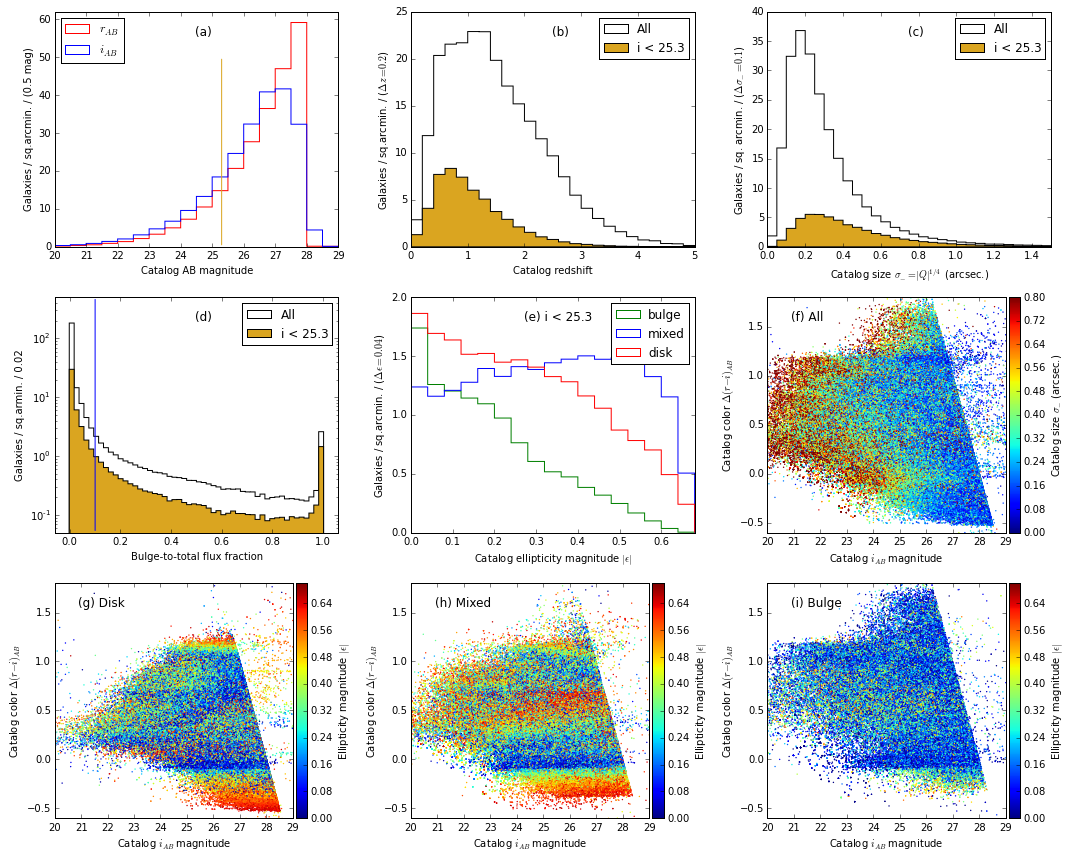

In [208]:
fig = plt.figure(figsize=(15,12))
nrow,ncol=3,3
# magnitude
plt.subplot(nrow,ncol,1)
abmin,abmax=20.,29.
nbins=18
plt.hist(catalog['r_ab'],bins=nbins,range=(abmin,abmax),histtype='step',
         weights=wgt,color='red',label='$r_{AB}$')
plt.hist(catalog['i_ab'],bins=nbins,range=(abmin,abmax),histtype='step',
         weights=wgt,color='blue',label='$i_{AB}$')
plt.xlim(abmin,abmax)
plt.ylim(0.,62.)
plt.xlabel('Catalog AB magnitude')
plt.ylabel('Galaxies / sq.arcmin. / (%.1f mag)' % ((abmax-abmin)/nbins))
plt.legend(loc = 'upper left')
plt.annotate('',xy=(25.3,0.),xytext=(25.3,50.),xycoords='data',textcoords='data',
             arrowprops={'arrowstyle':'-','color':'goldenrod'})
plt.annotate('(a)',xy=(0.5,0.9),xycoords='axes fraction',fontsize='large')
# redshift
plt.subplot(nrow,ncol,2)
zmax=5.
nbins=25
plt.hist(catalog['redshift'],bins=nbins,range=(0,zmax),histtype='step',color='black',
         weights=wgt,label='All')
plt.hist(catalog['redshift'][gold],bins=25,range=(0,5),histtype='stepfilled',
         weights=wgt[gold],facecolor='goldenrod',color='black',label='i < 25.3')
plt.xlabel('Catalog redshift')
plt.ylabel('Galaxies / sq.arcmin. / ($\Delta z = %.1f$)' % (zmax/nbins))
plt.legend()
plt.annotate('(b)',xy=(0.5,0.9),xycoords='axes fraction',fontsize='large')
# size
plt.subplot(nrow,ncol,3)
rmax=1.5
nbins=30
plt.hist(sigma_m,bins=nbins,range=(0,rmax),histtype='step',color='black',
         weights=wgt,label='All');
plt.hist(sigma_m[gold],bins=nbins,range=(0,rmax),histtype='stepfilled',
         facecolor='goldenrod',color='black',weights=wgt[gold],label='i < 25.3');
plt.xlim(0.,rmax)
plt.xlabel('Catalog size $\sigma_{-} = |Q|^{1/4}$ (arcsec.)')
plt.ylabel('Galaxies / sq. arcmin. / ($\Delta\sigma_{-}=%.1f$)' % (rmax/nbins))
plt.legend()
plt.annotate('(c)',xy=(0.5,0.9),xycoords='axes fraction',fontsize='large')
# bulge fraction
plt.subplot(nrow,ncol,4)
nbins=58
plt.hist(frac_bulge,bins=nbins,range=(-0.06,1.06),histtype='step',color='black',
         weights=wgt,label='All')
plt.hist(frac_bulge[gold],bins=nbins,range=(-0.06,1.06),histtype='stepfilled',color='goldenrod',
         weights=wgt[gold],label='i < 25.3')
plt.yscale('log')
plt.xlim(-0.06,1.06)
plt.ylim(5e-2,5e2)
plt.xlabel('Bulge-to-total flux fraction')
plt.ylabel('Galaxies / sq.armin. / %.2f' % (1./nbins))
plt.annotate('',xy=(cut2,5e-2),xytext=(cut2,5e2),xycoords='data',textcoords='data',
             arrowprops={'arrowstyle':'-','color':'blue'})
plt.legend()
plt.annotate('(d)',xy=(0.5,0.9),xycoords='axes fraction',fontsize='large')
# ellipticity magnitude
plt.subplot(nrow,ncol,5)
emax=0.68
nbins=17
plt.hist(
    (emag[gold_disk_only],emag[gold_disk_bulge],emag[gold_big_bulge]),
    bins=nbins,range=(0,emax),histtype='step',color=('red','blue','green'),
    weights=(wgt[gold_disk_only],wgt[gold_disk_bulge],wgt[gold_big_bulge]),
    stacked=False,label=('disk','mixed','bulge'))
plt.xlim(0,emax)
plt.xlabel('Catalog ellipticity magnitude $|\epsilon|$')
plt.ylabel('Galaxies / sq.arcmin. / ($\Delta\epsilon=%.2f$)' % (emax/nbins))
plt.legend()
plt.annotate('(e) i < 25.3',xy=(0.4,0.9),xycoords='axes fraction',fontsize='large')
# color-shape correlations
plt.subplot(nrow,ncol,6)
plt.scatter(catalog['i_ab'],ri_color,vmin=0.,vmax=0.8,
            s=2,c=sigma_m,lw=0,rasterized=True)
plt.colorbar(label='Catalog size $\sigma_{-}$ (arcsec.)',pad=0.01)
plt.xlim(abmin,abmax)
ri_min,ri_max = -0.6,+1.8
plt.ylim(ri_min,ri_max)
plt.xlabel('Catalog $i_{AB}$ magnitude')
plt.ylabel('Catalog color $\Delta (r-i)_{AB}$')
plt.annotate('(f) All',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
#
plt.subplot(nrow,ncol,7)
w=disk_only
plt.scatter(catalog['i_ab'][w],ri_color[w],vmin=0.,vmax=0.7,
            s=2,c=emag[w],lw=0,rasterized=True)
plt.colorbar(label='Ellipticity magnitude $|\epsilon|$',pad=0.01)
plt.xlim(abmin,abmax)
plt.ylim(ri_min,ri_max)
plt.xlabel('Catalog $i_{AB}$ magnitude')
plt.ylabel('Catalog color $\Delta (r-i)_{AB}$')
plt.annotate('(g) Disk',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
#
plt.subplot(nrow,ncol,8)
w=disk_bulge
plt.scatter(catalog['i_ab'][w],ri_color[w],vmin=0.,vmax=0.7,
            s=2,c=emag[w],lw=0,rasterized=True)
plt.colorbar(label='Ellipticity magnitude $|\epsilon|$',pad=0.01)
plt.xlim(abmin,abmax)
plt.ylim(ri_min,ri_max)
plt.xlabel('Catalog $i_{AB}$ magnitude')
plt.ylabel('Catalog color $\Delta (r-i)_{AB}$')
plt.annotate('(h) Mixed',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
#
plt.subplot(nrow,ncol,9)
w=big_bulge
plt.scatter(catalog['i_ab'][w],ri_color[w],vmin=0.,vmax=0.7,
            s=2,c=emag[w],lw=0,rasterized=True)
plt.colorbar(label='Ellipticity magnitude $|\epsilon|$',pad=0.01)
plt.xlim(abmin,abmax)
plt.ylim(ri_min,ri_max)
plt.xlabel('Catalog $i_{AB}$ magnitude')
plt.ylabel('Catalog color $\Delta (r-i)_{AB}$')
plt.annotate('(i) Bulge',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
#
plt.tight_layout();
fig.savefig('output/catalog_plots.pdf');